# Writing performant Julia code

## Introducing a toy example

In [2]:
function lap2d!(u, unew)
    M, N = size(u)
    for j in 2:N-1
        for i in 2:M-1
            unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end 
    end
end

lap2d! (generic function with 1 method)

In [3]:
function setup(N=4096, M=4096)
    u = zeros(M, N)
    # set boundary conditions
    u[1,:] = u[end,:] = u[:,1] = u[:,end] .= 10.0
    unew = copy(u);
    return u, unew
end

setup (generic function with 3 methods)

In [4]:
u, unew = setup()

([10.0 10.0 … 10.0 10.0; 10.0 0.0 … 0.0 10.0; … ; 10.0 0.0 … 0.0 10.0; 10.0 10.0 … 10.0 10.0], [10.0 10.0 … 10.0 10.0; 10.0 0.0 … 0.0 10.0; … ; 10.0 0.0 … 0.0 10.0; 10.0 10.0 … 10.0 10.0])

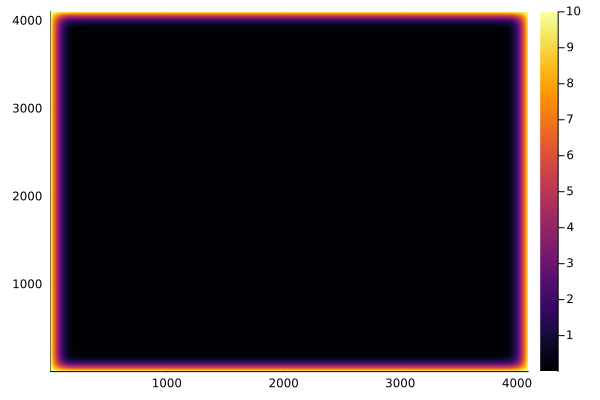

In [9]:
for i in 1:1000
    lap2d!(u, unew)
    # copy new computed field to old array
    u = copy(unew)
end

using Plots
heatmap(u)

## Benchmarking

In [11]:
using Pkg
Pkg.activate()
Pkg.add("BenchmarkTools")

  Activating project at `~/.julia/environments/v1.9`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [12]:
using BenchmarkTools
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 366 samples with 1 evaluation.
 Range (min … max):  13.611 ms … 14.181 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     13.676 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.683 ms ± 48.868 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▂ ▅▂▁ ▂▆▃█▃▂▂                                         
  ▃▄▄▅▇▇▇█▆███████████▇▆▆▇▇▆▆▅▆▄▃▅▃▃▄▃▃▃▃▃▃▃▄▃▁▃▃▁▁▃▁▁▁▁▁▁▁▁▃ ▄
  13.6 ms         Histogram: frequency by time        13.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [13]:
bench_results = @benchmark lap2d!(u, unew)
typeof(bench_results)
println(minimum(bench_results.times))

1.3605292e7


## Profiling

In [15]:
Pkg.add("Profile")
using Profile

Profile.clear() # clear backtraces from earlier runs
@profile lap2d!(u, unew)
Profile.print()

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [9abbd945] + Profile
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Overhead ╎ [+additional indent] Count File:Line; Function
  ╎10 @Base/task.jl:514; (::IJulia.var"#15#18")()
  ╎ 10 @IJulia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
  ╎  10 @Base/essentials.jl:816; invokelatest
  ╎   10 @Base/essentials.jl:819; #invokelatest#2
  ╎    10 ...c/execute_request.jl:67; execute_request(socket::ZMQ.Soc...
  ╎     10 .../SoftGlobalScope.jl:65; softscope_include_string(m::Mod...
  ╎    ╎ 10 @Base/loading.jl:1903; include_string(mapexpr::typeo...
  ╎    ╎  10 @Base/boot.jl:370; eval
  ╎    ╎   10 In[2]:5; lap2d!(u::Matrix{Float64}, une...
 8╎    ╎    8  @Base/array.jl:971; setindex!
 1╎    ╎    2  @Base/essentials.jl:14; getindex
Total snapshots: 20. Utilization: 100% across all threads and tasks. Use the `groupby` kwarg to break down by thread and/or task.


In [17]:
Pkg.add("ProfileView")
using ProfileView
@profview lap2d!(u, unew)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1,000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=2, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile  -  14:24:31", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip

## Optimization options

In [18]:
function lap2d!(u, unew)
    M, N = size(u)
    for i in 2:M-1
        for j in 2:N-1
            unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end
    end
end

lap2d! (generic function with 1 method)

In [20]:
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 33 samples with 1 evaluation.
 Range (min … max):  151.120 ms … 161.075 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     152.289 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   152.651 ms ±   1.636 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

        █▅                                                       
  ▄▁▄▅▄▄██▇▄▄▄▅▁▁▁▄▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  151 ms           Histogram: frequency by time          161 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
function lap2d!(u, unew)
    M, N = size(u)
    for j in 2:N-1
        for i in 2:M-1
            @inbounds unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end 
    end
end

lap2d! (generic function with 1 method)

In [22]:
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 663 samples with 1 evaluation.
 Range (min … max):  7.430 ms …  7.996 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.513 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.537 ms ± 82.272 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▃▆▆█▆▆▃▅▂▁▄ ▁▃▂▁                                         
  ▃▃▇████████████████▅▆▅▄▄▄▄▃▄▄▄▃▃▄▃▃▄▃▃▁▅▂▃▂▂▁▃▁▁▃▃▁▂▁▁▂▂▁▂ ▄
  7.43 ms        Histogram: frequency by time        7.86 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [26]:
Pkg.add("StaticArrays")
using StaticArrays
m1 = rand(10,10)
m2 = @SArray rand(10,10)

@btime m1*m1
# 311.808 ns (1 allocation: 896 bytes)

@btime m2*m2
# 99.902 ns (1 allocation: 816 bytes)

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [90137ffa] + StaticArrays v1.6.5
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


  222.745 ns (1 allocation: 896 bytes)
  88.505 ns (1 allocation: 816 bytes)


10×10 SMatrix{10, 10, Float64, 100} with indices SOneTo(10)×SOneTo(10):
 3.04371  1.82779  2.13958  2.43462  …  2.30464  1.98835  2.05592  1.85017
 2.95438  1.96527  2.78636  2.19125     2.91238  2.671    2.15903  1.66433
 2.31469  1.70258  2.85595  2.06283     1.96172  2.21275  2.05129  1.58431
 3.22384  2.18469  2.59302  3.17424     2.273    3.36339  2.58602  2.30335
 2.67128  2.2093   2.35438  2.52523     2.53752  3.43803  2.25908  1.95974
 3.58551  2.27571  2.97554  2.58883  …  2.94666  3.44053  2.72864  2.36663
 3.91952  3.02265  3.41036  3.28962     3.93443  3.79654  3.11153  2.50765
 2.9172   1.8061   2.60431  2.79896     2.25304  2.98273  2.26104  2.38386
 3.24377  1.87769  2.89994  2.51025     3.42833  3.30622  2.42492  2.18071
 2.9688   1.64249  2.13671  2.02398     2.31997  2.2678   1.96898  1.26212